In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as smt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.eval_measures import mse,rmse
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from keras.models import Sequential
pd.pandas.set_option('display.max_columns', None)
from pmdarima import auto_arima

Using TensorFlow backend.


In [2]:
df = pd.read_csv('Final_Data_3_28.csv', parse_dates=True)
df.head()

,TIME,STREET,DIRECTION,Avarage,Cong,S_length,BUS_COUNT,MESSAGE_COUNT,HOUR,DAY_OF_WEEK,MONTH,Zip,maxtempc,mintempC,totalSnow_cm,sunHour,uvIndex,uvIndex2,moon_illumination,moonrise,moonset,sunrise,sunset,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,3/15/2018 10:50,Fairbanks,SB,14,0.47,0.40,2,9,10,5,3,21182,5,0,0,11.6,1,1,2,6:18 AM,5:11 PM,7:02 AM,6:57 PM,-3,1,4,1,12,6,64,0,1012,3,10,202,10
1,3/16/2018 14:31,Lake Shore Dr,SW,0,0.00,0.50,0,0,14,6,3,21192,1,-2,0,8.7,1,1,0,6:50 AM,6:12 PM,7:01 AM,6:58 PM,-8,-4,0,-4,15,98,52,0,1022,0,10,63,13
2,3/21/2018 0:40,Higgins,NW,0,0.00,2.47,0,0,0,4,3,4448,2,-1,0,10.3,1,1,27,9:28 AM,11:42 PM,6:52 AM,7:04 PM,-5,-6,0,-6,31,100,68,0,1014,0,10,38,23
3,3/20/2018 22:31,130th,EB,30,1.00,3.07,1,5,22,3,3,4460,1,-2,0,11.6,1,1,20,8:52 AM,10:33 PM,6:54 AM,7:03 PM,-5,-5,1,-5,33,100,66,0,1015,1,10,27,25
4,3/20/2018 4:20,Dr Martin L King Jr,NB,0,0.00,9.04,0,0,4,3,3,4301,1,-2,0,11.6,1,1,20,8:52 AM,10:33 PM,6:54 AM,7:03 PM,-6,-8,-1,-8,37,8,68,0,1014,-1,10,46,28


In [3]:
df['TIME'] = df['TIME'].astype('datetime64[ns]')

In [4]:
col_list = ['TIME', 'STREET', 'DIRECTION', 'Avarage', 'Cong', 'S_length','BUS_COUNT',
            'MESSAGE_COUNT','windspeedKmph', 'mintempC']

In [5]:
df_p = df[col_list]
df_p.head()

,TIME,STREET,DIRECTION,Avarage,Cong,S_length,BUS_COUNT,MESSAGE_COUNT,windspeedKmph,mintempC
0,2018-03-15 10:50:00,Fairbanks,SB,14,0.47,0.40,2,9,10,0
1,2018-03-16 14:31:00,Lake Shore Dr,SW,0,0.00,0.50,0,0,13,-2
2,2018-03-21 00:40:00,Higgins,NW,0,0.00,2.47,0,0,23,-1
3,2018-03-20 22:31:00,130th,EB,30,1.00,3.07,1,5,25,-2
4,2018-03-20 04:20:00,Dr Martin L King Jr,NB,0,0.00,9.04,0,0,28,-2


In [6]:
df_p.shape

(123647, 10)

In [7]:
df_p['TIME'].dt.day.unique()

array([15, 16, 21, 20, 19, 17, 18, 14], dtype=int64)

In [8]:
df_Fairbanks_SB= df_p[(df_p['STREET']=='Fairbanks') & (df_p['DIRECTION']=='SB')]
df_Fairbanks_SB.shape

(1001, 10)

In [9]:
df_Fairbanks_SB = df_Fairbanks_SB.sort_values(by='TIME')
df_Fairbanks_SB.head()

,TIME,STREET,DIRECTION,Avarage,Cong,S_length,BUS_COUNT,MESSAGE_COUNT,windspeedKmph,mintempC
119727,2018-03-14 13:20:00,Fairbanks,SB,20,0.67,0.4,2,3,19,-4
25806,2018-03-14 13:30:00,Fairbanks,SB,15,0.50,0.4,3,10,19,-4
123202,2018-03-14 13:40:00,Fairbanks,SB,14,0.47,0.4,7,33,19,-4
104929,2018-03-14 13:50:00,Fairbanks,SB,17,0.57,0.4,1,4,19,-4
91227,2018-03-14 14:01:00,Fairbanks,SB,14,0.47,0.4,6,28,21,-4


In [10]:
df_Fairbanks_SB_T = df_Fairbanks_SB[(df_Fairbanks_SB['TIME'].dt.day == 14)|
                                    (df_Fairbanks_SB['TIME'].dt.day == 15)|(df_Fairbanks_SB['TIME'].dt.day == 16)|
                                    (df_Fairbanks_SB['TIME'].dt.day == 17)|(df_Fairbanks_SB['TIME'].dt.day == 18)|
                                    (df_Fairbanks_SB['TIME'].dt.day == 19)]
df_Fairbanks_SB_T.shape

(752, 10)

In [11]:
df_Fairbanks_SB_T.head()

,TIME,STREET,DIRECTION,Avarage,Cong,S_length,BUS_COUNT,MESSAGE_COUNT,windspeedKmph,mintempC
119727,2018-03-14 13:20:00,Fairbanks,SB,20,0.67,0.4,2,3,19,-4
25806,2018-03-14 13:30:00,Fairbanks,SB,15,0.50,0.4,3,10,19,-4
123202,2018-03-14 13:40:00,Fairbanks,SB,14,0.47,0.4,7,33,19,-4
104929,2018-03-14 13:50:00,Fairbanks,SB,17,0.57,0.4,1,4,19,-4
91227,2018-03-14 14:01:00,Fairbanks,SB,14,0.47,0.4,6,28,21,-4


In [12]:
df_Fairbanks_SB_Ts = df_Fairbanks_SB[(df_Fairbanks_SB['TIME'].dt.day == 20)|(df_Fairbanks_SB['TIME'].dt.day == 21)]
df_Fairbanks_SB_Ts.shape

(249, 10)

In [13]:
df_Fairbanks_SB_T = df_Fairbanks_SB_T.sort_values(by='TIME')
df_Fairbanks_SB_Ts.head()

,TIME,STREET,DIRECTION,Avarage,Cong,S_length,BUS_COUNT,MESSAGE_COUNT,windspeedKmph,mintempC
56559,2018-03-20 00:01:00,Fairbanks,SB,25,0.83,0.4,2,12,27,-2
60155,2018-03-20 00:10:00,Fairbanks,SB,20,0.67,0.4,1,3,27,-2
116357,2018-03-20 00:20:00,Fairbanks,SB,24,0.80,0.4,1,12,27,-2
53065,2018-03-20 00:30:00,Fairbanks,SB,24,0.80,0.4,1,9,27,-2
74173,2018-03-20 00:40:00,Fairbanks,SB,10,0.33,0.4,1,4,27,-2


In [14]:
col_list_2 = ['TIME','Cong']
Train = df_Fairbanks_SB_T[col_list_2]
Test = df_Fairbanks_SB_Ts[col_list_2]
Total = df_Fairbanks_SB[col_list_2]
print('Total Dim: ', Total.shape)
print('Train dim: ',Train.shape)
print('Test dim: ',Test.shape)

Total Dim:  (1001, 2)
Train dim:  (752, 2)
Test dim:  (249, 2)


In [15]:
tt= Total.copy()
tt.shape

(1001, 2)

In [16]:
tt.head(20)

,TIME,Cong
119727,2018-03-14 13:20:00,0.67
25806,2018-03-14 13:30:00,0.50
123202,2018-03-14 13:40:00,0.47
104929,2018-03-14 13:50:00,0.57
91227,2018-03-14 14:01:00,0.47
115869,2018-03-14 14:10:00,0.53
51957,2018-03-14 14:20:00,0.70
87446,2018-03-14 14:31:00,0.70
59224,2018-03-14 14:40:00,0.53
117346,2018-03-14 14:50:00,0.67


In [17]:
tt['TIME']=tt['TIME'].dt.round('10min')
tt.head(20)

,TIME,Cong
119727,2018-03-14 13:20:00,0.67
25806,2018-03-14 13:30:00,0.50
123202,2018-03-14 13:40:00,0.47
104929,2018-03-14 13:50:00,0.57
91227,2018-03-14 14:00:00,0.47
115869,2018-03-14 14:10:00,0.53
51957,2018-03-14 14:20:00,0.70
87446,2018-03-14 14:30:00,0.70
59224,2018-03-14 14:40:00,0.53
117346,2018-03-14 14:50:00,0.67


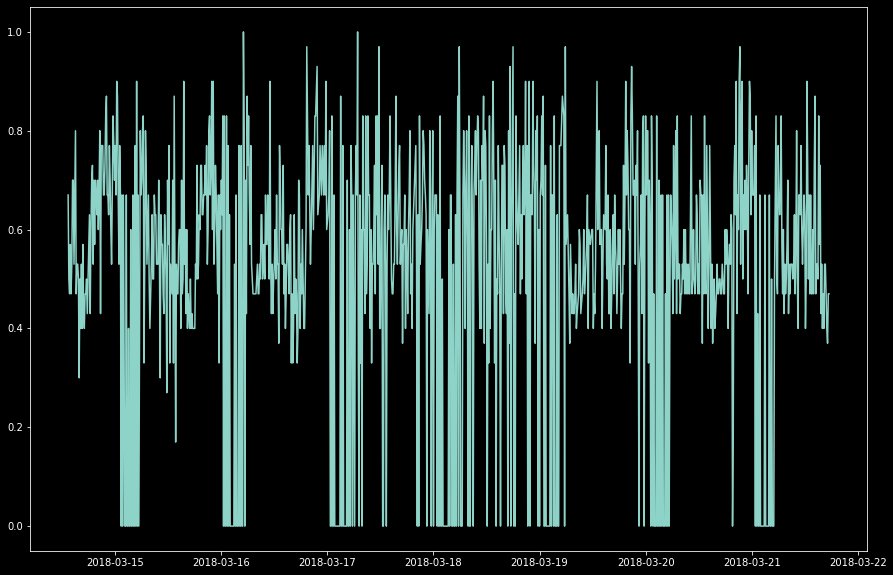

In [18]:

plt.style.use('dark_background')
plt.figure(figsize = (15,10))
plt.plot(tt['TIME'], tt['Cong']);

In [19]:
tt.loc[tt['Cong']==0.0]

,TIME,Cong
16978,2018-03-15 01:20:00,0.0
103335,2018-03-15 01:40:00,0.0
78022,2018-03-15 02:10:00,0.0
101910,2018-03-15 02:20:00,0.0
108447,2018-03-15 02:40:00,0.0
...,...,...
74119,2018-03-21 04:10:00,0.0
75764,2018-03-21 04:20:00,0.0
95530,2018-03-21 04:40:00,0.0
91129,2018-03-21 04:50:00,0.0


In [20]:
tt['Cong'] = tt['Cong'].replace(0.0, 0.50)

In [21]:
tt.loc[tt['Cong']==0.0]

,TIME,Cong


In [22]:
tt.shape

(1001, 2)

In [23]:
tt = tt.set_index('TIME').asfreq('10Min')

In [24]:
tt.shape

(1034, 1)

In [25]:
tt.head(20)

,Cong
TIME,
2018-03-14 13:20:00,0.67
2018-03-14 13:30:00,0.50
2018-03-14 13:40:00,0.47
2018-03-14 13:50:00,0.57
2018-03-14 14:00:00,0.47
2018-03-14 14:10:00,0.53
2018-03-14 14:20:00,0.70
2018-03-14 14:30:00,0.70
2018-03-14 14:40:00,0.53


In [26]:
tt.groupby([tt.index.day, tt.index.hour]).transform(lambda x: x.fillna(x.mean()))

,Cong
TIME,
2018-03-14 13:20:00,0.67
2018-03-14 13:30:00,0.50
2018-03-14 13:40:00,0.47
2018-03-14 13:50:00,0.57
2018-03-14 14:00:00,0.47
...,...
2018-03-21 16:50:00,0.47
2018-03-21 17:00:00,0.40
2018-03-21 17:10:00,0.37


In [27]:
tt.loc[tt['Cong']>0]

,Cong
TIME,
2018-03-14 13:20:00,0.67
2018-03-14 13:30:00,0.50
2018-03-14 13:40:00,0.47
2018-03-14 13:50:00,0.57
2018-03-14 14:00:00,0.47
...,...
2018-03-21 16:50:00,0.47
2018-03-21 17:00:00,0.40
2018-03-21 17:10:00,0.37


In [28]:
tt.tail(5)

,Cong
TIME,
2018-03-21 16:50:00,0.47
2018-03-21 17:00:00,0.40
2018-03-21 17:10:00,0.37
2018-03-21 17:20:00,0.47
2018-03-21 17:30:00,0.47


In [29]:
for i, row in tt.iterrows():
#     a=0.0
    
    if row.Cong>0.0:
        pass
    else:
        print(row.Cong)
        b=0.5
#         print(row.Index)
        tt.at[i,'Cong']=b

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [30]:
tt.tail(5)

,Cong
TIME,
2018-03-21 16:50:00,0.47
2018-03-21 17:00:00,0.40
2018-03-21 17:10:00,0.37
2018-03-21 17:20:00,0.47
2018-03-21 17:30:00,0.47


In [31]:
train = tt.iloc[:746]
test = tt.iloc[746:]

fitted_model = ExponentialSmoothing(train['Cong'], trend='mul',seasonal= 'add',seasonal_periods=144).fit()

C:\Users\mosto\Anaconda3\envs\RTX-GPU\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\mosto\Anaconda3\envs\RTX-GPU\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
C:\Users\mosto\Anaconda3\envs\RTX-GPU\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [32]:
test_predictions = fitted_model.forecast(288)

In [33]:
test_predictions


2018-03-19 17:40:00    0.470284
2018-03-19 17:50:00    0.514126
2018-03-19 18:00:00    0.556437
2018-03-19 18:10:00    0.494779
2018-03-19 18:20:00    0.485972
                         ...   
2018-03-21 16:50:00    0.493890
2018-03-21 17:00:00    0.543925
2018-03-21 17:10:00    0.466637
2018-03-21 17:20:00    0.569388
2018-03-21 17:30:00    0.541020
Freq: 10T, Length: 288, dtype: float64

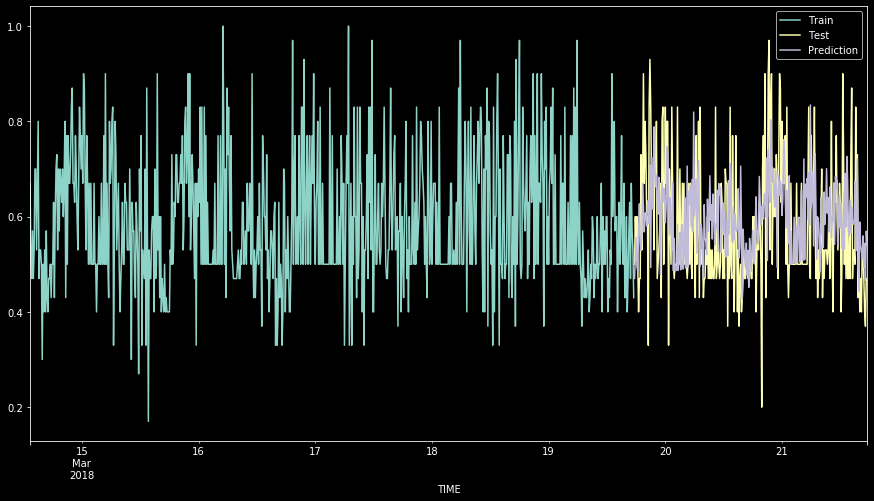

In [34]:
train['Cong'].plot(legend=True,label='Train',figsize=(15,8))
test['Cong'].plot(legend=True,label='Test')
test_predictions.plot(legend=True,label='Prediction')

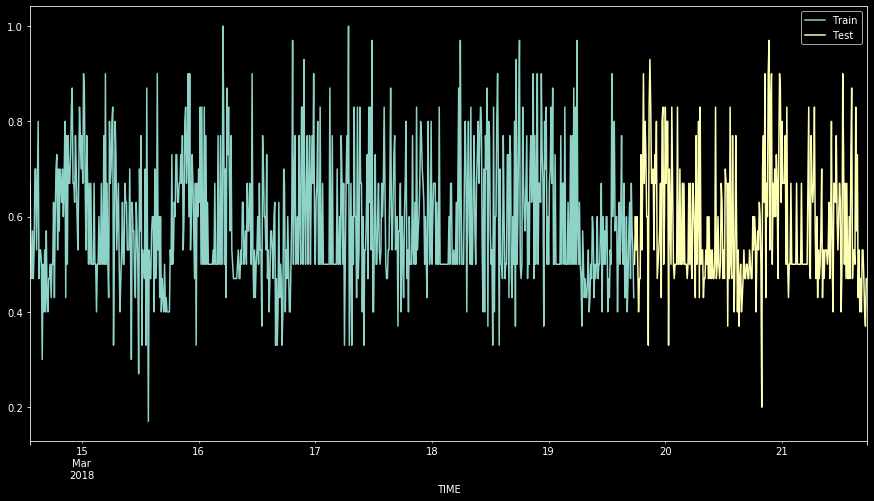

In [35]:
train['Cong'].plot(legend=True,label='Train',figsize=(15,8))
test['Cong'].plot(legend=True,label='Test')
# test_predictions.plot(legend=True,label='Prediction')

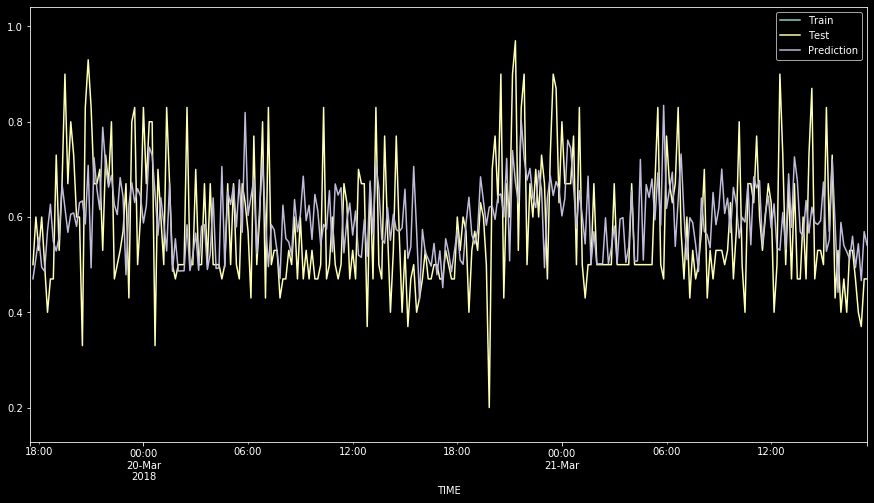

In [36]:
train['Cong'].plot(legend=True,label='Train',figsize=(15,8))
test['Cong'].plot(legend=True,label='Test')
test_predictions.plot(legend=True,label='Prediction',xlim=['2018-03-19 17:30:00','2018-03-21 17:30:00'])

In [37]:
pred_mse = mse(test['Cong'], test_predictions)
pred_rmse = rmse(test['Cong'], test_predictions)

In [38]:
print(pred_mse)
print(pred_rmse)

0.017390518497889477
0.13187311514440492


In [39]:
train.shape, test.shape

((746, 1), (288, 1))

In [40]:
train.head()

,Cong
TIME,
2018-03-14 13:20:00,0.67
2018-03-14 13:30:00,0.50
2018-03-14 13:40:00,0.47
2018-03-14 13:50:00,0.57
2018-03-14 14:00:00,0.47


In [41]:
train.tail()

,Cong
TIME,
2018-03-19 16:50:00,0.47
2018-03-19 17:00:00,0.67
2018-03-19 17:10:00,0.57
2018-03-19 17:20:00,0.53
2018-03-19 17:30:00,0.43


In [42]:
tt.head()

,Cong
TIME,
2018-03-14 13:20:00,0.67
2018-03-14 13:30:00,0.50
2018-03-14 13:40:00,0.47
2018-03-14 13:50:00,0.57
2018-03-14 14:00:00,0.47


In [43]:
tt.shape

(1034, 1)

In [44]:
# stepwise_fit = auto_arima(train['Cong'], maxiter=10, seasonal=True, d=None, trace=True, m=144, error_action='ignore', suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic


KeyboardInterrupt: 

In [48]:
from pmdarima import auto_arima

stepwise_model = auto_arima(tt, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=144,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)


Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 144) (constant=True); AIC=-870.582, BIC=-846.631, Time=552.893 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 144) (constant=True); AIC=53.684, BIC=63.265, Time=16.445 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 144) (constant=True); AIC=-377.175, BIC=-358.014, Time=169.735 seconds
Near non-invertible roots for order (1, 1, 0)(1, 1, 0, 144); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.994)
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 144) (constant=True); AIC=-870.664, BIC=-851.504, Time=622.493 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 144); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 144) (constant=False); AIC=51.685, BIC=56.475, Time=9.653 seconds
Fit ARIMA: (1, 1, 1)x(0, 1, 0, 144) (constant=True); AIC=-559.246, BIC=-540.085, Time=92.012 seconds
Fit ARIMA: (1, 1, 1)x(1, 1, 1, 144) 

MemoryError: Unable to allocate 1.46 GiB for an array with shape (435, 435, 1034) and data type float64

# See the seasonality and Trend using Seasonal Decomposition 

In [ ]:
decompfreq = 6*24
decomposition = sm.tsa.seasonal_decompose(tt.values, period=decompfreq)
trend = decomposition.trend

In [ ]:
decomposition.plot();

## Dickey–Fuller test method

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [ ]:
adf_test(tt)

### Run auto arima to get best model result for p,q,d and seasonality

In [ ]:
stepwise_fit = auto_arima(tt['Cong'], maxiter=10, seasonal=True, d=None, trace=True, m=144, error_action='ignore', suppress_warnings=True, stepwise=True)

In [ ]:
stepwise_fit.summary()

### Fit sariman according to auto arima order. 

In [ ]:
model = SARIMAX(tt['Cong'], order=(0,0,1), seasonal_order=(0,0,1,144), enforce_invertibility=False)
results = model.fit()
results.summary()

In [ ]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=True).rename('SARIMA(0,0,1)(0,0,1,144) Predictions')

In [ ]:
title='Chicago Traffic Congestion'
ylabel='Congestion Ratio'
xlabel=''

ax = test['Cong'].plot(legend=True,figsize=(16,7),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [ ]:
error1 = mse(test['Cong'], predictions)
error2 = rmse(test['Cong'], predictions)

In [ ]:
print(error1)
print(error2)

In [ ]:
model = SARIMAX(tt['Cong'],order=(0,0,1),seasonal_order=(0,0,1,144))
results = model.fit()
fcast = results.predict(len(tt),len(tt)+36,typ='levels').rename('SARIMA(0,0,1)(0,0,1,144) Forecast')

In [ ]:
title = 'Chicago Traffic Congestion'
ylabel='Congestion Ratio'
xlabel=''

ax = tt.plot(legend=True,figsize=(16,10),title=title)
fcast.plot(legend=True, xlim=['2018-03-18 17:30:00','2018-03-21 17:30:00'])
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);